In [227]:
import numpy as np
import pandas as pd
import scanpy as sc
import networkx as nx
import matplotlib.pyplot as plt
import os

# 1. ldsc的遗传关联

In [230]:

ldsc_rg = pd.read_csv(r"E:\00_CeSOP\data\ldsc_rg_matrix.csv",index_col=0)
traits = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
# 更换性状名字
ldsc_rg = ldsc_rg.reset_index()  # 重置索引，将当前索引变成列
ldsc_rg = ldsc_rg.merge(traits[['Trait', 'Trait name']], how='left', left_on='index', right_on='Trait')  # 合并 df2 中的新索引
ldsc_rg.set_index('Trait name', inplace=True)  # 设置新索引
ldsc_rg.drop(['index', 'Trait'], axis=1, inplace=True)  # 删除多余列
ldsc_rg.columns = ldsc_rg.index

In [231]:
# 将相似性矩阵转化成边

# 转换为数值类型
ldsc_rg = ldsc_rg.astype(float)
ldsc_rg_list = []
rows, cols = ldsc_rg.shape
for i in range(rows):
    for j in range(i + 1, cols):
        ldsc_rg_list.append(
            (ldsc_rg.index[i], ldsc_rg.columns[j], ldsc_rg.iat[i, j]))
# 转换为DataFrame并显示
ldsc_rg_df = pd.DataFrame(ldsc_rg_list, columns=['Node1', 'Node2', 'value'])
ldsc_rg_df.to_csv(r"E:\00_CeSOP\results\ldsc_rg\edges.csv",index = None)
pd.DataFrame(ldsc_rg.columns) .to_csv(r"E:\00_CeSOP\results\ldsc_rg\nodes.csv",index = None)

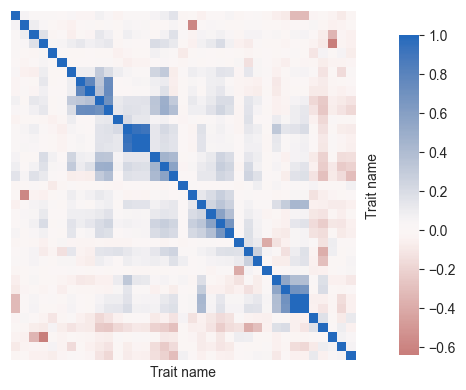

In [232]:
import seaborn as sns

g = sns.clustermap(ldsc_rg, cmap='vlag_r', figsize=(4, 4), linewidths=0,
                   # xticklabels=False, yticklabels=True,
                   xticklabels=False, yticklabels=False,
                   dendrogram_ratio=(0.001, 0.001),
                   # method='average', metric='euclidean',
                   method='complete', metric='cosine',
                   cbar_pos=(1.01, 0.1, 0.05, 0.8),
                   center=0)

In [207]:
'''提取聚类结果'''
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

# ldsc
cosine_distance = pdist(ldsc_rg, metric='cosine')  # Transpose to calculate column distances
linkage_matrix = sch.linkage(cosine_distance, method='complete')
array = ldsc_rg.to_numpy()
cluster_assignments = sch.fcluster(linkage_matrix, t=2, criterion='maxclust')
ldsc_rg['Cluster'] = cluster_assignments


In [218]:
'''将CeSOP方法与ldsc发现的遗传关联热图组合在一起 '''
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

epsilon = 1e-10
core = "core"
traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
traits37 = ldsc_rg.index
## 只列出37个性状
for trait_name in traits37:
    trait = traits_name[traits_name["Trait name"] == trait_name]["Number"].values[0]
    df = pd.read_csv(
        r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\%s\top10_%s_lcczscore.csv" % (trait, core))
    df = df.sort_values("tissue")
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]
alltraits_significant.index = df["tissue"]
alltraits_significant_T = alltraits_significant.T

# '''计算每两列(性状）之间的余弦相似度'''
# cosine_similarities = pd.DataFrame(index=alltraits_significant.columns, columns=alltraits_significant.columns)
# for col1 in alltraits_significant.columns:
#     for col2 in alltraits_significant.columns:
#         if col1 != col2:
#             cosine_similarities.loc[col1, col2] = 1 - cosine(alltraits_significant[col1], alltraits_significant[col2])
#         else:
#             cosine_similarities.loc[col1, col2] = 1  # 自身与自身的相似度为1
# 
# # 转换为数值类型
# cosine_similarities = cosine_similarities.astype(float)
# g = sns.clustermap(cosine_similarities, cmap='Blues', 
#                    figsize=(4, 4), linewidths=0,
#                    xticklabels=False, yticklabels=False,
#                    dendrogram_ratio=(0.001, 0.001),
#                    method='complete', metric='cosine',
#                    cbar_pos=(1.01, 0.1, 0.05, 0.8),
#                    center=0.6)
# cosine_similarities_list = []
# rows, cols = cosine_similarities.shape
# for i in range(rows):
#     for j in range(i + 1, cols):
#         rows, cols = cosine_similarities.shape
#         cosine_similarities_list.append(
#             (cosine_similarities.index[i], cosine_similarities.columns[j], cosine_similarities.iat[i, j]))
# # 转换为DataFrame并显示
# cosine_similarities_df = pd.DataFrame(cosine_similarities_list, columns=['Node1', 'Node2', 'value'])
# cosine_similarities_df.to_csv(r"E:\00_CeSOP\results\ldsc_rg\cesop\tissues\edges.csv",index = None)

'''提取聚类结果'''

# 计算余弦距离矩阵
cosine_distance = pdist(alltraits_significant_T, metric='cosine')  # Transpose to calculate column distances
linkage_matrix = sch.linkage(cosine_distance, method='complete')
array = alltraits_significant_T.to_numpy()
cluster_assignments = sch.fcluster(linkage_matrix, t=2, criterion='maxclust')
# 添加簇分配结果到 DataFrame
alltraits_significant_T['Cluster'] = cluster_assignments



In [220]:
'''将ldsc的结果当做label，计算聚类指标'''
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(ldsc_rg['Cluster'], alltraits_significant_T['Cluster'])
print(f'Adjusted Rand Index: {ari}')

from sklearn.metrics import normalized_mutual_info_score
nmi = normalized_mutual_info_score(ldsc_rg['Cluster'], alltraits_significant_T['Cluster'])
print(f'Normalized Mutual Information: {nmi}')

from sklearn.metrics import fowlkes_mallows_score
fm_index = fowlkes_mallows_score(ldsc_rg['Cluster'], alltraits_significant_T['Cluster'])
print(f'Fowlkes-Mallows Index: {fm_index}')


Adjusted Rand Index: 0.018723918295629256
Normalized Mutual Information: 0.010737520156627219
Fowlkes-Mallows Index: 0.617694709282805


In [225]:
ldsc_rg['Cluster'].to_csv(r"E:\00_CeSOP\results\temp\temp.csv")

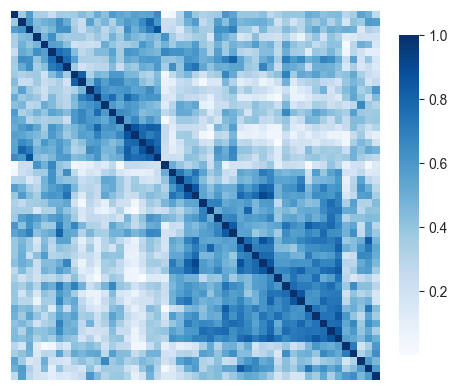

In [223]:
epsilon = 1e-10
core = "core"
traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
for trait in range(1, 50):
    trait_name = traits_name[traits_name["Number"] == trait]["Trait name"].values[0]
    # trait_name = traits_name[traits_name["Number"] == trait]["Trait 名字"].values[0]
    df = pd.read_csv(
        r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\%s\top10_%s_lcczscore.csv" % (trait, core))
    df = df.sort_values("tissue")
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]
alltraits_significant.index = df["tissue"]
alltraits_significant_T = alltraits_significant.T

'''计算每两列(性状）之间的余弦相似度'''
cosine_similarities = pd.DataFrame(index=alltraits_significant.columns, columns=alltraits_significant.columns)
for col1 in alltraits_significant.columns:
    for col2 in alltraits_significant.columns:
        if col1 != col2:
            cosine_similarities.loc[col1, col2] = 1 - cosine(alltraits_significant[col1], alltraits_significant[col2])
        else:
            cosine_similarities.loc[col1, col2] = 1  # 自身与自身的相似度为1
# 转换为数值类型
cosine_similarities = cosine_similarities.astype(float)

g = sns.clustermap(cosine_similarities, cmap='Blues', 
                   figsize=(4, 4), linewidths=0,
                   xticklabels=False, yticklabels=False,
                   dendrogram_ratio=(0.001, 0.001),
                   # method='average', metric='euclidean',
                   # method='complete', metric='euclidean',
                   method='complete', metric='cosine',
                   cbar_pos=(1.01, 0.1, 0.05, 0.8),
                   center=0.5)
# g = sns.clustermap(cosine_similarities, cmap='Blues', figsize=(10, 12), linewidths=0,
#                    xticklabels=False, yticklabels=True,
#                    # method='average', metric='euclidean',
#                    method='complete', metric='cosine',
#                    center=0.45)

cosine_similarities_T = cosine_similarities.T

'''提取聚类结果'''
# 计算余弦距离矩阵
cosine_distance = pdist(cosine_similarities_T, metric='cosine')  # Transpose to calculate column distances
# 生成层次聚类
linkage_matrix = sch.linkage(cosine_distance, method='complete')
# 划分簇，设置簇数为3
array = cosine_similarities_T.iloc[:, 0:-1].to_numpy()
cluster_assignments = sch.fcluster(linkage_matrix, t=2, criterion='maxclust')
# 添加簇分配结果到 DataFrame
cosine_similarities_T['Cluster'] = cluster_assignments


In [226]:
cosine_similarities_T['Cluster'].to_csv(r"E:\00_CeSOP\results\temp\temp1.csv")

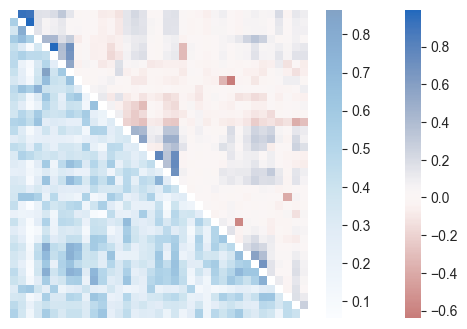

In [154]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list

# 层次聚类并根据聚类结果对数据进行排序
linkage_matrix = linkage(ldsc_rg, method='average')
dendro = dendrogram(linkage_matrix, no_plot=True)
ordered_indices = leaves_list(linkage_matrix)

# 根据聚类结果排序矩阵
ordered_corr_matrix1 = ldsc_rg.iloc[ordered_indices, ordered_indices]
ordered_corr_matrix2 = cosine_similarities.iloc[ordered_indices, ordered_indices]

# 创建一个包含两个热力图的矩阵
mask_upper = np.triu(np.ones_like(ordered_corr_matrix1, dtype=bool))
mask_lower = np.tril(np.ones_like(ordered_corr_matrix2, dtype=bool))

# 绘制热力图
plt.figure(figsize=(6, 4))
ax = sns.heatmap(ordered_corr_matrix1, mask=mask_lower, cmap='vlag_r',center = 0)
sns.heatmap(ordered_corr_matrix2, mask=mask_upper,  cmap='Blues', ax=ax, center=0.5,alpha = 0.5)
# 隐藏 x 和 y 坐标
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
# 调整热力图的显示
# ax.set_title('Combined Heatmaps with Hierarchical Clustering')
plt.show()


No NaN or inf values in the data.


PermissionError: [Errno 13] Permission denied: 'E:\\00_CeSOP\\results\\ldsc_rg\\cesop\\celltypes\\edges.csv'

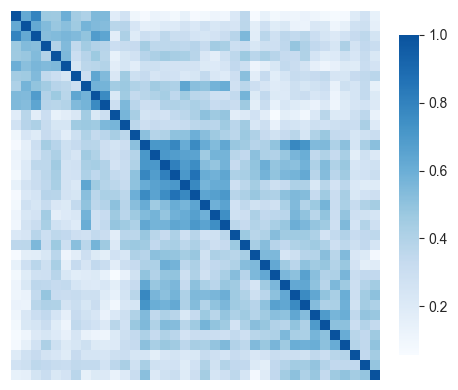

In [155]:
'''根据细胞类型特异性对性状进行聚类，并输出聚类结果'''

traits_name = pd.read_excel(r"E:\00_CeSOP\data\49_traits.xlsx")
alltraits_significant = pd.DataFrame()
traits37 = ldsc_rg.columns
## 只列出37个性状
for trait_name in traits37:
    trait = traits_name[traits_name["Trait name"] == trait_name]["Number"].values[0]
    df = pd.read_csv(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\celltypes\%s\top10_%s_lcczscore.csv"%(trait,core))
    df = df.sort_values(["tissue","celltype"])  
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + + epsilon)
    alltraits_significant[trait_name] = df["log fisher's pvalue"]
alltraits_significant.index = df["tissue"] + "---" + df["celltype"]
# 处理NaN和inf值
alltraits_significant = alltraits_significant.replace([np.inf, -np.inf], np.nan).dropna()
# 检查是否有NaN或inf值
if alltraits_significant.isnull().values.any():
    print("Data contains NaN or inf values.")
else:
    print("No NaN or inf values in the data.")

'''层次聚类'''
alltraits_significant_T = alltraits_significant.T
x = -np.log10(0.005 + epsilon)
# cg = sns.clustermap(alltraits_significant_T, cmap='Greens', 
#                     yticklabels=True, xticklabels=False,
#                     method='weighted', metric='correlation',
#                     # method='complete', metric='cosine',
#                     cbar_pos=(0.05, 0.87, 0.02, 0.1),
#                     cbar_kws={'ticks': [0, x, 10]},
#                     center=x)  #行是组织，列是性状

'''计算每两列(性状）之间的余弦相似度'''
cosine_similarities = pd.DataFrame(index=alltraits_significant.columns, columns=alltraits_significant.columns)
for col1 in alltraits_significant.columns:
    for col2 in alltraits_significant.columns:
        if col1 != col2:
            cosine_similarities.loc[col1, col2] = 1 - cosine(alltraits_significant[col1], alltraits_significant[col2])
        else:
            cosine_similarities.loc[col1, col2] = 1  # 自身与自身的相似度为1

# 转换为数值类型
cosine_similarities = cosine_similarities.astype(float)
g = sns.clustermap(cosine_similarities, cmap='Blues', 
                   figsize=(4, 4), linewidths=0,
                   xticklabels=False, yticklabels=False,
                   dendrogram_ratio=(0.001, 0.001),
                   method='complete', metric='cosine',
                   cbar_pos=(1.01, 0.1, 0.05, 0.8),
                   center=0.6)
cosine_similarities_list = []
rows, cols = cosine_similarities.shape
for i in range(rows):
    for j in range(i + 1, cols):
        rows, cols = cosine_similarities.shape
        cosine_similarities_list.append(
            (cosine_similarities.index[i], cosine_similarities.columns[j], cosine_similarities.iat[i, j]))
# 转换为DataFrame并显示
cosine_similarities_df = pd.DataFrame(cosine_similarities_list, columns=['Node1', 'Node2', 'value'])
cosine_similarities_df.to_csv(r"E:\00_CeSOP\results\ldsc_rg\cesop\celltypes\edges.csv",index = None)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list

# 层次聚类并根据聚类结果对数据进行排序
linkage_matrix = linkage(ldsc_rg, method='average')
dendro = dendrogram(linkage_matrix, no_plot=True)
ordered_indices = leaves_list(linkage_matrix)

# 根据聚类结果排序矩阵
ordered_corr_matrix1 = ldsc_rg.iloc[ordered_indices, ordered_indices]
ordered_corr_matrix2 = cosine_similarities.iloc[ordered_indices, ordered_indices]

# 创建一个包含两个热力图的矩阵
mask_upper = np.triu(np.ones_like(ordered_corr_matrix1, dtype=bool))
mask_lower = np.tril(np.ones_like(ordered_corr_matrix2, dtype=bool))

# 绘制热力图
plt.figure(figsize=(6, 4))
ax = sns.heatmap(ordered_corr_matrix1, mask=mask_lower, cmap='vlag_r',center = 0)
sns.heatmap(ordered_corr_matrix2, mask=mask_upper,  cmap='Blues', ax=ax, center=0.5,alpha = 0.5)
# 隐藏 x 和 y 坐标
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
# 调整热力图的显示
# ax.set_title('Combined Heatmaps with Hierarchical Clustering')
plt.show()


NameError: name 'ldsc_rg' is not defined

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
'''将CeSOP方法与ldsc发现的性状遗传关联做散点图 '''
ct_traits = pd.read_csv(r"E:\00_CeSOP\results\ldsc_rg\cesop\celltypes\edges.csv")[["Node1","Node2","value"]]
t_traits = pd.read_csv(r"E:\00_CeSOP\results\ldsc_rg\cesop\tissues\edges.csv")[["Node1","Node2","value"]]
ldsc_traits = pd.read_csv(r"E:\00_CeSOP\results\ldsc_rg\ldsc\edges.csv")[["Node1","Node2","value"]]

ct_traits = ct_traits.sort_values(["Node1","Node2"]).reset_index()
t_traits = t_traits.sort_values(["Node1","Node2"]).reset_index()
ldsc_traits = ldsc_traits.sort_values(["Node1","Node2"]).reset_index()

df = pd.concat([ct_traits, t_traits,ldsc_traits], axis = 1, ignore_index=True)
df_results = df.iloc[:,[1,2,3,7,11]]
df_results.columns = ["Node1","Node2","Corr_tissues","Corr_celltypes","Ldsc_rg"]

In [5]:
print(df_results["Ldsc_rg"].mean())
print(df_results["Ldsc_rg"].std())

print(df_results["Corr_tissues"].mean())
print(df_results["Corr_tissues"].std())

print(df_results["Corr_celltypes"].mean())
print(df_results["Corr_celltypes"].std())

0.041373573573573574
0.15803513093253824
0.3699397015540541
0.14894145838875597
0.4463906628201554
0.18121338736232803



余弦相似度:
0.2869085148637152


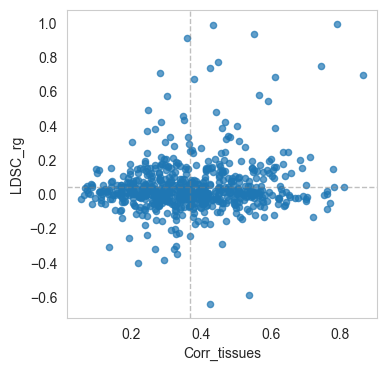

In [7]:
# 计算均值
mean_x = df_results["Corr_tissues"].mean()
mean_y = df_results["Ldsc_rg"].mean()

fig = plt.figure(figsize = (4,4))
plt.scatter(df_results["Corr_tissues"],df_results["Ldsc_rg"],s = 20,alpha = 0.7)
# 添加 x 方向的均值虚线
plt.axvline(x=mean_x, color='grey', linestyle='--', linewidth=1,alpha=0.5)
# 添加 y 方向的均值虚线
plt.axhline(y=mean_y, color='grey', linestyle='--', linewidth=1,alpha=0.5)

plt.xlabel("Corr_tissues")
plt.ylabel("LDSC_rg")
plt.grid(False)

from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(df_results["Corr_tissues"].values.reshape(1, -1), df_results["Ldsc_rg"].values.reshape(1, -1))[0, 0]
print("\n余弦相似度:")
print(cosine_sim)


余弦相似度:
0.9422278679033211


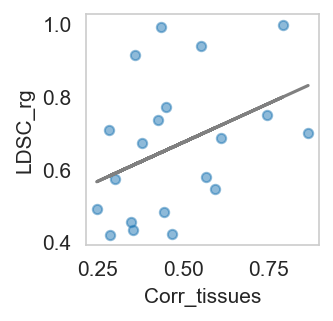

In [20]:
'''只画出LDSC高遗传关联的散点'''
df_results_filtered = df_results[df_results["Ldsc_rg"]>0.4]
x = df_results_filtered["Corr_tissues"]
y = df_results_filtered["Ldsc_rg"]

# 计算线性回归
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(df_results_filtered["Corr_tissues"], df_results_filtered["Ldsc_rg"])
line1 = slope1 * df_results_filtered["Corr_tissues"] + intercept1

fig = plt.figure(figsize = (2,2),dpi = 150)
plt.scatter(x,y,s = 20,alpha = 0.5)
plt.plot(df_results_filtered["Corr_tissues"], line1, color='grey')
plt.xlabel("Corr_tissues")
plt.ylabel("LDSC_rg")
plt.grid(False)

from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(df_results_filtered["Corr_tissues"].values.reshape(1, -1), df_results_filtered["Ldsc_rg"].values.reshape(1, -1))[0, 0]
print("\n余弦相似度:")
print(cosine_sim)


余弦相似度:
0.2761308092918349


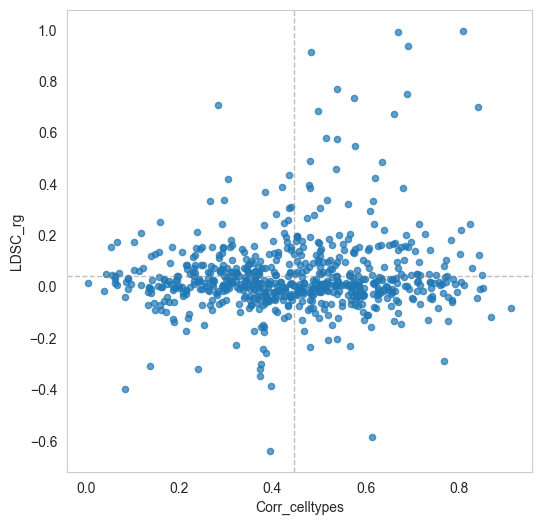

In [186]:
# 计算均值
mean_x = df_results["Corr_celltypes"].mean()
mean_y = df_results["Ldsc_rg"].mean()

fig = plt.figure(figsize = (6,6))
plt.scatter(df_results["Corr_celltypes"],df_results["Ldsc_rg"],s = 20,alpha = 0.7)
# 添加 x 方向的均值虚线
plt.axvline(x=mean_x, color='grey', linestyle='--', linewidth=1,alpha=0.5)
# 添加 y 方向的均值虚线
plt.axhline(y=mean_y, color='grey', linestyle='--', linewidth=1,alpha=0.5)
plt.xlabel("Corr_celltypes")
plt.ylabel("LDSC_rg")
plt.grid(False)

from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(df_results["Corr_celltypes"].values.reshape(1, -1), df_results["Ldsc_rg"].values.reshape(1, -1))[0, 0]
print("\n余弦相似度:")
print(cosine_sim)


余弦相似度:
0.9640522570501311


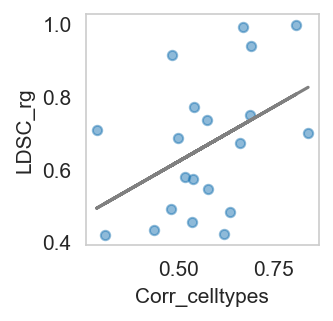

In [22]:
'''只画出LDSC高遗传关联的散点'''
df_results_filtered = df_results[df_results["Ldsc_rg"]>0.4]
x = df_results_filtered["Corr_celltypes"]
y = df_results_filtered["Ldsc_rg"]

# 计算线性回归
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(df_results_filtered["Corr_celltypes"], df_results_filtered["Ldsc_rg"])
line1 = slope1 * df_results_filtered["Corr_celltypes"] + intercept1

fig = plt.figure(figsize = (2,2),dpi = 150)
plt.scatter(x,y,s = 20,alpha = 0.5)
plt.plot(df_results_filtered["Corr_celltypes"], line1, color='grey')
plt.xlabel("Corr_celltypes")
plt.ylabel("LDSC_rg")
plt.grid(False)

from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(df_results_filtered["Corr_celltypes"].values.reshape(1, -1), df_results_filtered["Ldsc_rg"].values.reshape(1, -1))[0, 0]
print("\n余弦相似度:")
print(cosine_sim)

In [199]:
import plotly.express as px
import pandas as pd
df_results['label'] = df_results['Node1'] + ', ' + df_results['Node2']
# 创建交互式散点图
fig = px.scatter(df_results, x="Corr_tissues", y='Ldsc_rg',  hover_data={'Ldsc_rg': False, 'Corr_tissues': False, 'label': True})
# 更新布局以显示标签
fig.update_traces(textposition='top center')
# 显示图形
fig.show()

In [197]:
import plotly.express as px
import pandas as pd
df_results['label'] = df_results['Node1'] + ', ' + df_results['Node2']
# 创建交互式散点图
fig = px.scatter(df_results, x="Corr_celltypes", y='Ldsc_rg',  hover_data={'Ldsc_rg': False, 'Corr_celltypes': False, 'label': True})
# 更新布局以显示标签
fig.update_traces(textposition='top center')
# 显示图形
fig.show()

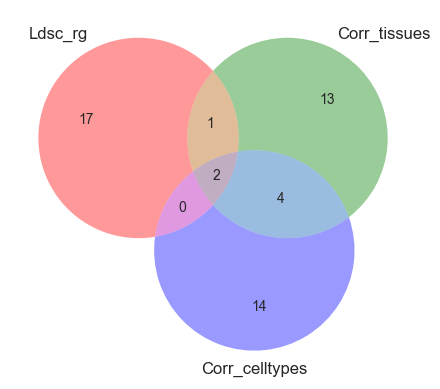

In [183]:
'''三组遗传关联的topk交集'''
k = 20
top10_df1 = df_results.nlargest(k, 'Ldsc_rg')
result_list1 = (top10_df1['Node1'] + "+"+ top10_df1['Node2']).tolist()

top10_df2 = df_results.nlargest(k, 'Corr_tissues')
result_list2 = (top10_df2['Node1'] + "+"+ top10_df2['Node2']).tolist()

top10_df3 = df_results.nlargest(k, 'Corr_celltypes')
result_list3 = (top10_df3['Node1'] + "+"+ top10_df3['Node2']).tolist()

from matplotlib_venn import venn3

# 将列表转换为集合
set1 = set(result_list1)
set2 = set(result_list2)
set3 = set(result_list3)
# 创建维恩图
venn3([set1, set2, set3], ('Ldsc_rg', 'Corr_tissues', 'Corr_celltypes'))
# 显示图形
plt.show()